In [1]:
import torch
from pathlib import Path
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('..'))
from HGCR_util.emb_lookup.abstr_emb_lookup import MedlineNumpyEmbeddings
from HGCR_util import text_util
from HGCR_util.lazy_json_kv_loader import LazyJsonlAbstractLoader
from agatha_construct.semrep_handler import SemRepHandler
from source.RelationClassifier import RelationClassifier
from utils.TermEmbedder import TermEmbedder
import numpy as np
import itertools
import random
random.seed(42)

In [2]:
import importlib
import source

importlib.reload(source.RelationClassifier)

<module 'source.RelationClassifier' from '/work/acslab/users/manning/NLM_soft/agatha_0724/BioPredClassifier/source/RelationClassifier.py'>

In [93]:
class RelationClassifierDemo:
    def __init__(self, model_path, embeddings_fpath, sent_jsonl_dir, nlm_soft_folder, sr_temp_folder, sr_replace_utf8_path, device='cpu'):
        self.device = device
        self.model = self.load_model(model_path)
        print("Model loaded successfully.")
        self.pubmedncl_emb_obj = MedlineNumpyEmbeddings(emb_w_ids_fpath=Path(embeddings_fpath), json_read_n_jobs=8)
        self.abstr_db = LazyJsonlAbstractLoader(list(sent_jsonl_dir.glob('*jsonl')))
        print("Abstract embeddings loaded successfully.")
        self.t = SemRepHandler(nlm_soft_path=nlm_soft_folder, temp_folder=sr_temp_folder, replace_utf8_path=sr_replace_utf8_path)
        self.t.sr_binary_path = Path('/work/acslab/users/manning/NLM_soft/public_semrep/bin/semrep.v1.9_2021AB')        
        print('SemRep loaded successfully.')
        self.embedder = TermEmbedder()
        self.last_results = {}
    
    def load_model(self, model_path, input_dim=2304):
        model = RelationClassifier(input_dim)
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        model.to(self.device)
        model.eval()
        return model

    def get_abstract_text(self, pmid):
        return text_util.get_abstr_text(pmid, self.abstr_db)

    def get_abstract_embedding(self, pmid):
        return self.pubmedncl_emb_obj[pmid]

    def get_sr_outputs(self, pmid, abstract):
        input_dict = {pmid: abstract}
        sr_output = self.t.ProcessList_parallel(input_dict)
        return sr_output
    
    def get_term_embeddings(self, terms):
        return self.embedder._batch_term_embeds(terms)

    def generate_sentence_data(self, sr_output, abstract_embedding, embed_dict):
        results_by_sentence = []

        for sentence_id, sent_data in sr_output.items():
            terms = [t['extracted_text'] for t in sent_data.get('terms', []) if t.get('extracted_text')]
            if len(terms) < 2:
                continue

            sent_text = sent_data.get('sent_text')
            rels = sent_data.get('relations', [])

            pos_pairs = set()
            for r in rels:
                subj, obj = r.get('subj_text'), r.get('obj_text')
                if subj and obj:
                    pos_pairs.add(tuple(sorted((subj, obj))))

            all_pairs = set(tuple(sorted(p)) for p in itertools.combinations(terms, 2))
            neg_pairs = all_pairs - pos_pairs

            labeled_pairs = [(pair, 1) for pair in pos_pairs] + [(pair, 0) for pair in neg_pairs]

            sentence_result = {'sentence': sent_text, 'pairs': []}
            for (subj, obj), label in labeled_pairs:
                if subj not in embed_dict or obj not in embed_dict:
                    continue

                pair_emb = np.concatenate((abstract_embedding, embed_dict[subj], embed_dict[obj]))
                with torch.no_grad():
                    input_tensor = torch.tensor(pair_emb, dtype=torch.float32)
                    score = self.model(input_tensor).item()

                sentence_result['pairs'].append({
                    'pair': (subj, obj), 
                    'label': label,
                    'score': score
                })
            sentence_result['pairs'].sort(key=lambda x: x['score'], reverse=True)

            results_by_sentence.append(sentence_result)

        return results_by_sentence
            
    def prepare_pmid_data(self, pmid=None):
        abstract_text = self.get_abstract_text(pmid)
        abstract_embedding = self.get_abstract_embedding(pmid)

        sr_output = self.get_sr_outputs(pmid, abstract_text)
        all_terms, sr_pairs, negative_pairs, other_neg_pairs = self.generate_negatives(sr_output)
        
        embed_dict = self.get_term_embeddings(list(all_terms))
        all_pairs = sr_pairs + negative_pairs
        labels = [1] * len(sr_pairs) + [0] * len(negative_pairs)

        pair_embeds = [
            (embed_dict[subj], embed_dict[obj])
            for subj, obj in all_pairs
            if subj in embed_dict and obj in embed_dict
        ]
        
        data, final_pairs, final_labels = [], [], []
        for (subj, obj), (subj_emb, obj_emb), label in zip(all_pairs, pair_embeds, labels):
            if abstract_embedding is not None and subj_emb is not None and obj_emb is not None:
                combined_emb = np.concatenate((abstract_embedding, subj_emb, obj_emb))
                data.append(combined_emb)
                final_pairs.append((subj, obj))
                final_labels.append(label)
        return np.array(data), final_pairs, final_labels, abstract_text

    def run_inference(self, model, data, pairs, labels):
        scores = []
        for pair, input_emb, label in zip(pairs, data, labels):
            with torch.no_grad():
                input_tensor = torch.tensor(input_emb, dtype=torch.float32)
                score = model(input_tensor).squeeze()
            scores.append((pair, score, label))
        return scores

    
    def predict_relations_from_pmid(self, pmid):
        abstract_text = self.get_abstract_text(pmid)
        abstract_embedding = self.get_abstract_embedding(pmid)
        sr_output = self.get_sr_outputs(pmid, abstract_text)

        all_terms = set()
        for sent in sr_output.values():
            all_terms.update(t['extracted_text'] for t in sent.get('terms', []))

        embed_dict = self.get_term_embeddings(list(all_terms))
        results_by_sentence = self.generate_sentence_data(sr_output, abstract_embedding, embed_dict)

        self.last_results = {
            'pmid': pmid,
            'abstract': abstract_text,
            'sentences': results_by_sentence
        }

        print(f"Results for PMID: {pmid}")
        print(f"Abstract text: {abstract_text}")
        for sent_data in results_by_sentence:
            print(f"Sentence: {sent_data['sentence']}")
            for pair_info in sent_data['pairs']:
                print(f"  Pair: {pair_info['pair']}, Score: {pair_info['score']:.4f}, Label: {pair_info['label']}")

            print()

        return results_by_sentence
        

    




        

In [80]:
demo = RelationClassifierDemo(
    model_path = '../models/60000_pmid_model.pth',
    embeddings_fpath = '/work/acslab/shared/medline_embeddings/PubMedNCL_abstr/abstr_id_to_emb_PubMedNCL',
    sent_jsonl_dir = Path(
    '/work/acslab/shared/Agatha_shared/'
    'pmid_to_sent_id_w_text_kv_jsonl_lazy_chunks'
    ),
    nlm_soft_folder = '/work/acslab/users/manning/NLM_soft',
    sr_temp_folder = '/work/acslab/users/manning/scratch_dir/sr_temp/021225',
    sr_replace_utf8_path = '/work/acslab/users/manning/NLM_soft/replace_utf8.jar'
)

Model loaded successfully.


Opening np chunks: 100%|████████████████████| 102/102 [00:00<00:00, 1087.92it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the enviro

Abstract embeddings loaded successfully.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


SemRep loaded successfully.


In [125]:
demo1 = RelationClassifierDemo(
    model_path = '../models/60000_pmid_model_v4.pth',
    embeddings_fpath = '/work/acslab/shared/medline_embeddings/PubMedNCL_abstr/abstr_id_to_emb_PubMedNCL',
    sent_jsonl_dir = Path(
    '/work/acslab/shared/Agatha_shared/'
    'pmid_to_sent_id_w_text_kv_jsonl_lazy_chunks'
    ),
    nlm_soft_folder = '/work/acslab/users/manning/NLM_soft',
    sr_temp_folder = '/work/acslab/users/manning/scratch_dir/sr_temp/021225',
    sr_replace_utf8_path = '/work/acslab/users/manning/NLM_soft/replace_utf8.jar'
)

Model loaded successfully.


Opening np chunks: 100%|██████████████████████| 102/102 [00:04<00:00, 25.24it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the enviro

Abstract embeddings loaded successfully.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


SemRep loaded successfully.


In [156]:
pmid = '33343298'
results = demo1.predict_relations_from_pmid(pmid)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Run SemRep in interactive mode...
Processing input with replace_utf8.jar utility...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Results for PMID: 33343298
Abstract text: New Insights Into Drug Discovery Targeting Tau Protein. Microtubule-associated protein tau is characterized by the fact that it is an intrinsically disordered protein due to its lack of a stable conformation and high flexibility. Intracellular inclusions of fibrillar forms of tau with a beta-sheet structure accumulate in the brain of patients with Alzheimer's disease and other tauopathies. Accordingly, detachment of tau from microtubules and transition of tau from a disordered state to an abnormally aggregated state are essential events preceding the onset of tau-related diseases. Many reports have shown that this transition is caused by post-translational modifications, including hyperphosphorylation and acetylation. The misfolded tau is self-assembled and forms a tau oligomer before the appearance of tau inclusions. Animal and pathological studies using human samples have demonstrated that tau oligomer formation contributes to neuronal loss. 

In [127]:
import matplotlib.pyplot as plt

In [152]:
def plot_score_histogram(results):
    for idx, sent_data in enumerate(results):
        scores = [p['score'] for p in sent_data['pairs']]
        pos_scores = [p['score'] for p in sent_data['pairs'] if p['label'] == 1]

        if not scores:
            continue

        plt.figure(figsize=(8,4))
        plt.hist(scores, bins=30, alpha=0.7, label='All scores')
        for ps in pos_scores:
            plt.axvline(x=ps, color='r', linestyle='--', linewidth=1)
        plt.title(f"Sentence {idx+1}: Score Distribution")
        plt.xlabel("Score")
        plt.xlim(0,1)
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

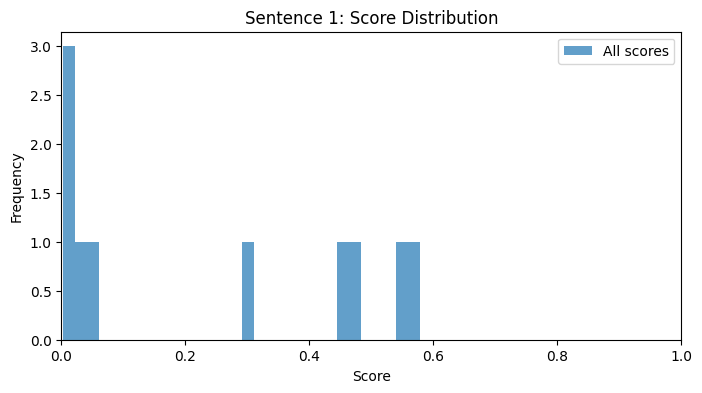

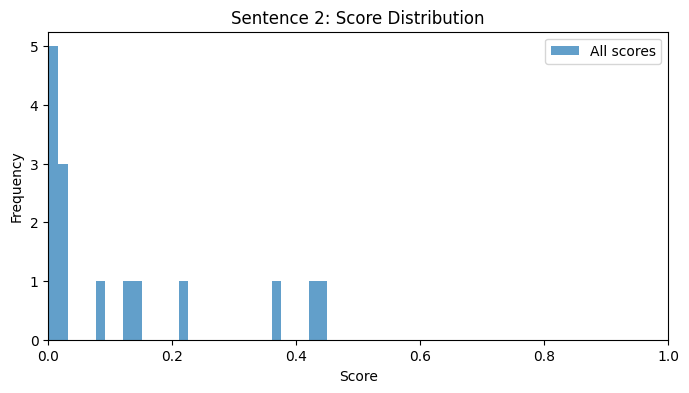

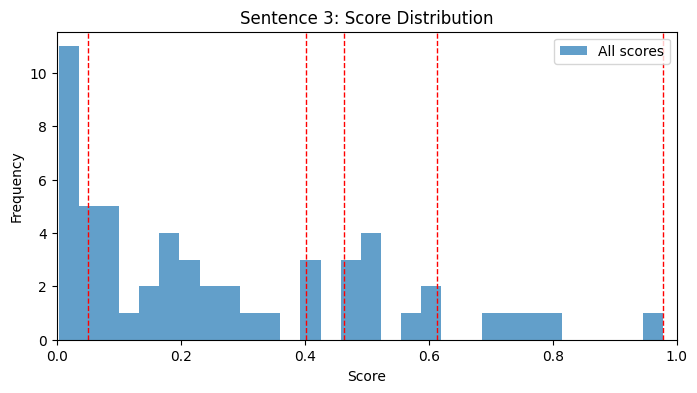

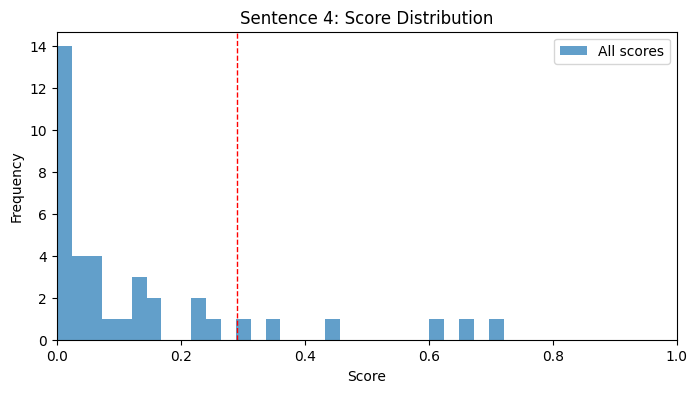

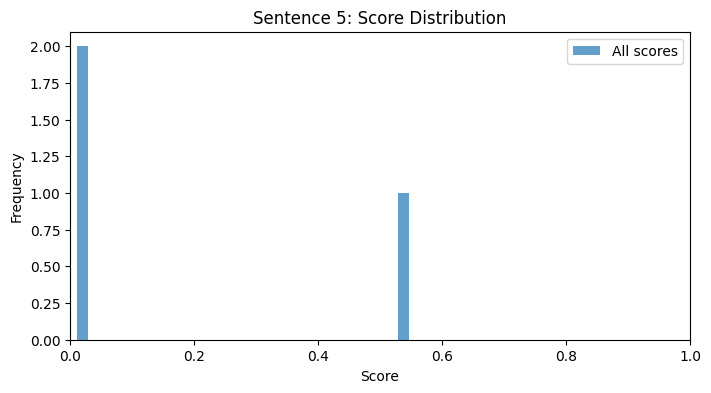

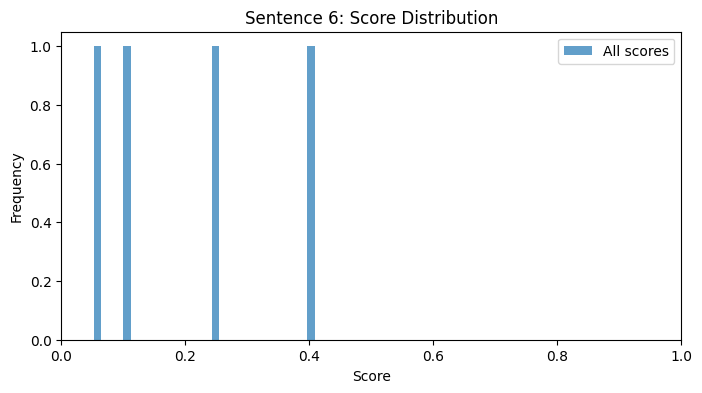

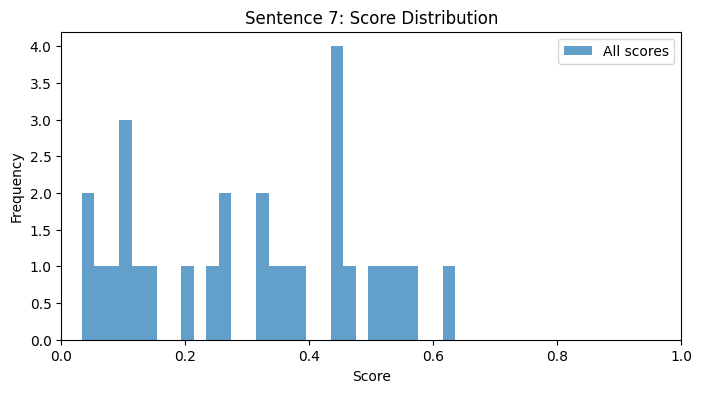

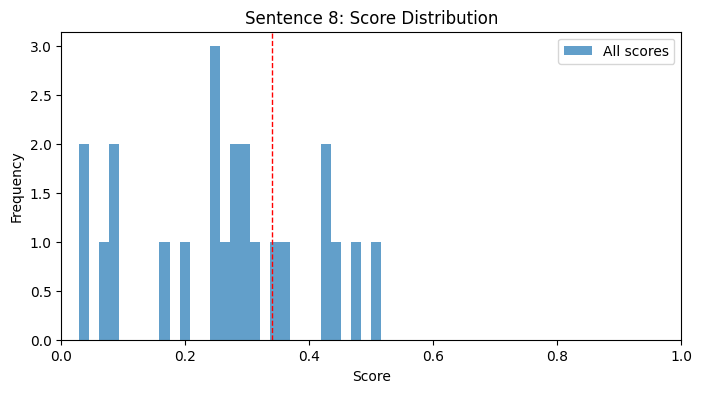

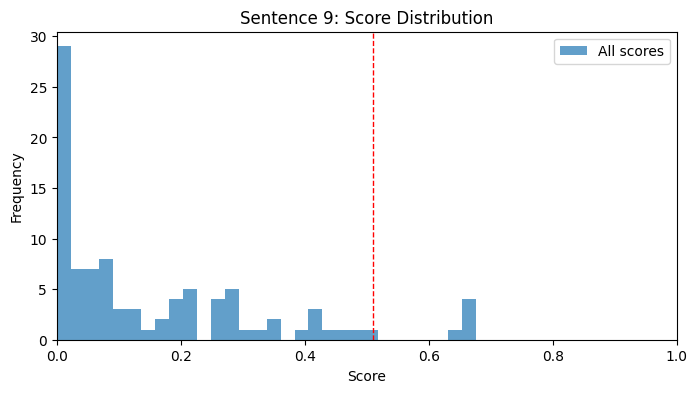

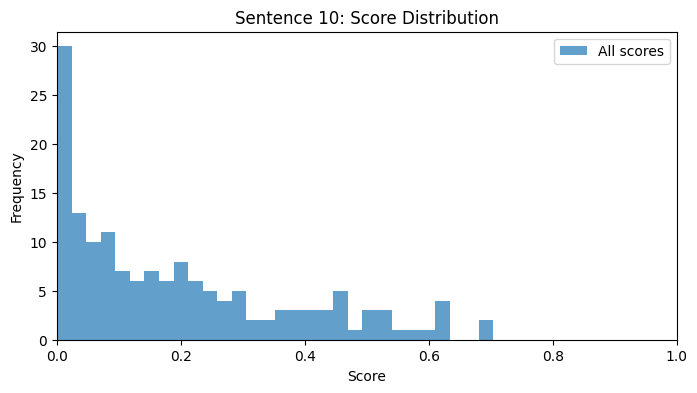

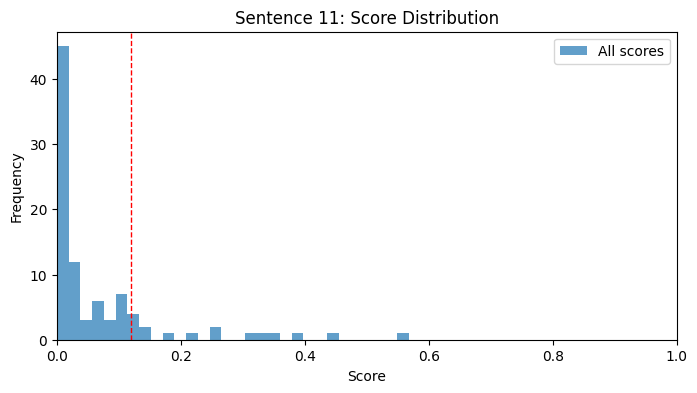

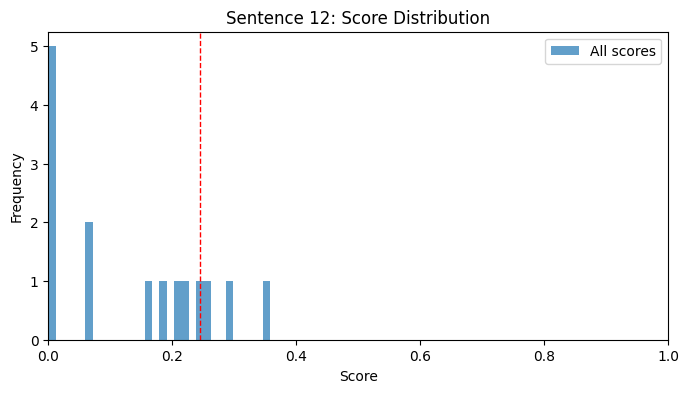

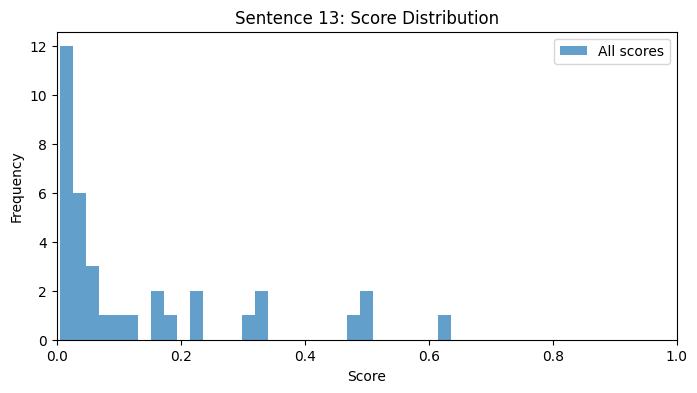

In [157]:
plot_score_histogram(demo1.last_results['sentences'])